<a href="https://colab.research.google.com/github/quinnouyang/Bodaway-Gap-Research/blob/main/dynamics-modeling/reservoir_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Reservoir Dynamics Modeling

This is the core part of modeling water infrastructure as an optimization problem, where we model the natural water dynamics (percipitation, evaporation, overflow, etc.) of a particular reservoir using various metereological, bathymetric, etc. data.


## Imports


In [29]:
from pyomo.environ import (
    SolverFactory,
    ConcreteModel,
    RangeSet,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeReals  # type: ignore
from dynamics_modeling.utils import linear_volume_area, power_law_volume_area

import numpy as np
import matplotlib.pyplot as plt
import scienceplots as _

plt.style.use("ieee")

### Optimization Setup and Model Inputs


In [34]:
SOLVER = SolverFactory("ipopt")
SOLVER.options["max_iter"] = 10000

PAN_COEFF = 0.8
INFIL_COEFF = 0.3
IN_TO_M = 0.0254
WIDTH = 0.25

N_POINTS = 12  # TODO: Shouldn't this be `N_PERIODS`?

EVAP_RATE = (
    PAN_COEFF
    * IN_TO_M
    * np.array(
        [
            2.45,
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            2.45,
        ]
    )  # Pan evaporation rate (in / period)
)  # (m / period)

CATCHMENT_AREA = PAN_COEFF * 1.6 * 1e7  # (m^2)
MAX_AREA = 21085  # (m^2)
GAMMA_1, GAMMA_2 = 1.4534, 1.1919
MAX_VOLUME = power_law_volume_area(MAX_AREA, GAMMA_1, GAMMA_2)
MAX_PUMP_RATE = 0  # (m^3 / period)
PRECIP = (
    INFIL_COEFF
    * CATCHMENT_AREA
    * IN_TO_M
    * np.array(
        [0.55, 0.51, 0.59, 0.28, 0.31, 0.16, 0.67, 0.71, 0.98, 0.87, 0.43, 0.31]
    )  # Precipitation rate (in / period)
)  # (m^3 / period)

### Define Model


In [35]:
def est_volume(area: float, use_linear=True) -> float:
    return (
        linear_volume_area(area, MAX_AREA, MAX_VOLUME)
        if use_linear
        else power_law_volume_area(area, GAMMA_1, GAMMA_2)
    )


model = ConcreteModel()

# Set `K` of period indices
model.K_periods = RangeSet(0, N_POINTS - 1)
model.K_points = RangeSet(0, N_POINTS)

# Variables
model.V = Var(model.K_points, domain=NonNegativeReals)  # Volume
model.S = Var(model.K_points, domain=NonNegativeReals)  # Storage
model.A = Var(model.K_points, domain=NonNegativeReals)  # Surface area
model.E = Var(model.K_periods, domain=NonNegativeReals)  # Evaporation
model.Q = Var(model.K_periods, domain=NonNegativeReals)  # Pumping
model.W = Var(model.K_periods, domain=NonNegativeReals)  # Overflow

# Objective function
model.min_overflow = Objective(
    expr=lambda model: sum(model.W[k] for k in model.K_periods)
)

# Constraints
model.volumetric_balance = Constraint(
    model.K_periods,
    rule=lambda model, k: model.V[k + 1]
    == model.S[k] + PRECIP[k] - model.E[k] - model.Q[k],
)  # [1]

model.overflow = Constraint(
    model.K_periods,
    rule=lambda model, k: model.W[k]
    == (model.V[k + 1] - MAX_VOLUME + abs(model.V[k + 1] - MAX_VOLUME)) / 2,
)  # [2]

model.evaporation = Constraint(
    model.K_periods,
    rule=lambda model, k: model.E[k]
    == (model.A[k] + model.A[k + 1]) / 2 * EVAP_RATE[k],
)  # [7]

model.bound_storage = Constraint(
    model.K_periods,
    rule=lambda model, k: model.S[k + 1] == model.V[k + 1] - model.W[k],
)  # [3]

model.storage_to_area = Constraint(
    model.K_points,
    rule=lambda model, k: model.S[k] == est_volume(model.A[k]),
)  # [4]

# model.bound_area = Constraint(
#     model.K_points, rule=lambda model, k: model.A[k] <= A
# )  # [5] (TODO: Check if actually redundant)

model.bound_pumping = Constraint(
    model.K_periods, rule=lambda model, k: model.Q[k] <= MAX_PUMP_RATE
)  # [8]

### Solve Model


In [32]:
SOLVER.solve(model)
model.pprint()

2 RangeSet Declarations
    K_periods : Dimen=1, Size=12, Bounds=(0, 11)
        Key  : Finite : Members
        None :   True :  [0:11]
    K_points : Dimen=1, Size=13, Bounds=(0, 12)
        Key  : Finite : Members
        None :   True :  [0:12]

6 Var Declarations
    A : Size=13, Index=K_points
        Key : Lower : Value                  : Upper : Fixed : Stale : Domain
          0 :     0 : -7.417474689664106e-10 :  None : False : False : NonNegativeReals
          1 :     0 :      5448.445148534665 :  None : False : False : NonNegativeReals
          2 :     0 :     10470.626607172582 :  None : False : False : NonNegativeReals
          3 :     0 :     16169.189392706112 :  None : False : False : NonNegativeReals
          4 :     0 :     18652.061625764025 :  None : False : False : NonNegativeReals
          5 :     0 :                21085.0 :  None : False : False : NonNegativeReals
          6 :     0 :                21085.0 :  None : False : False : NonNegativeReals
     

### Plot Model


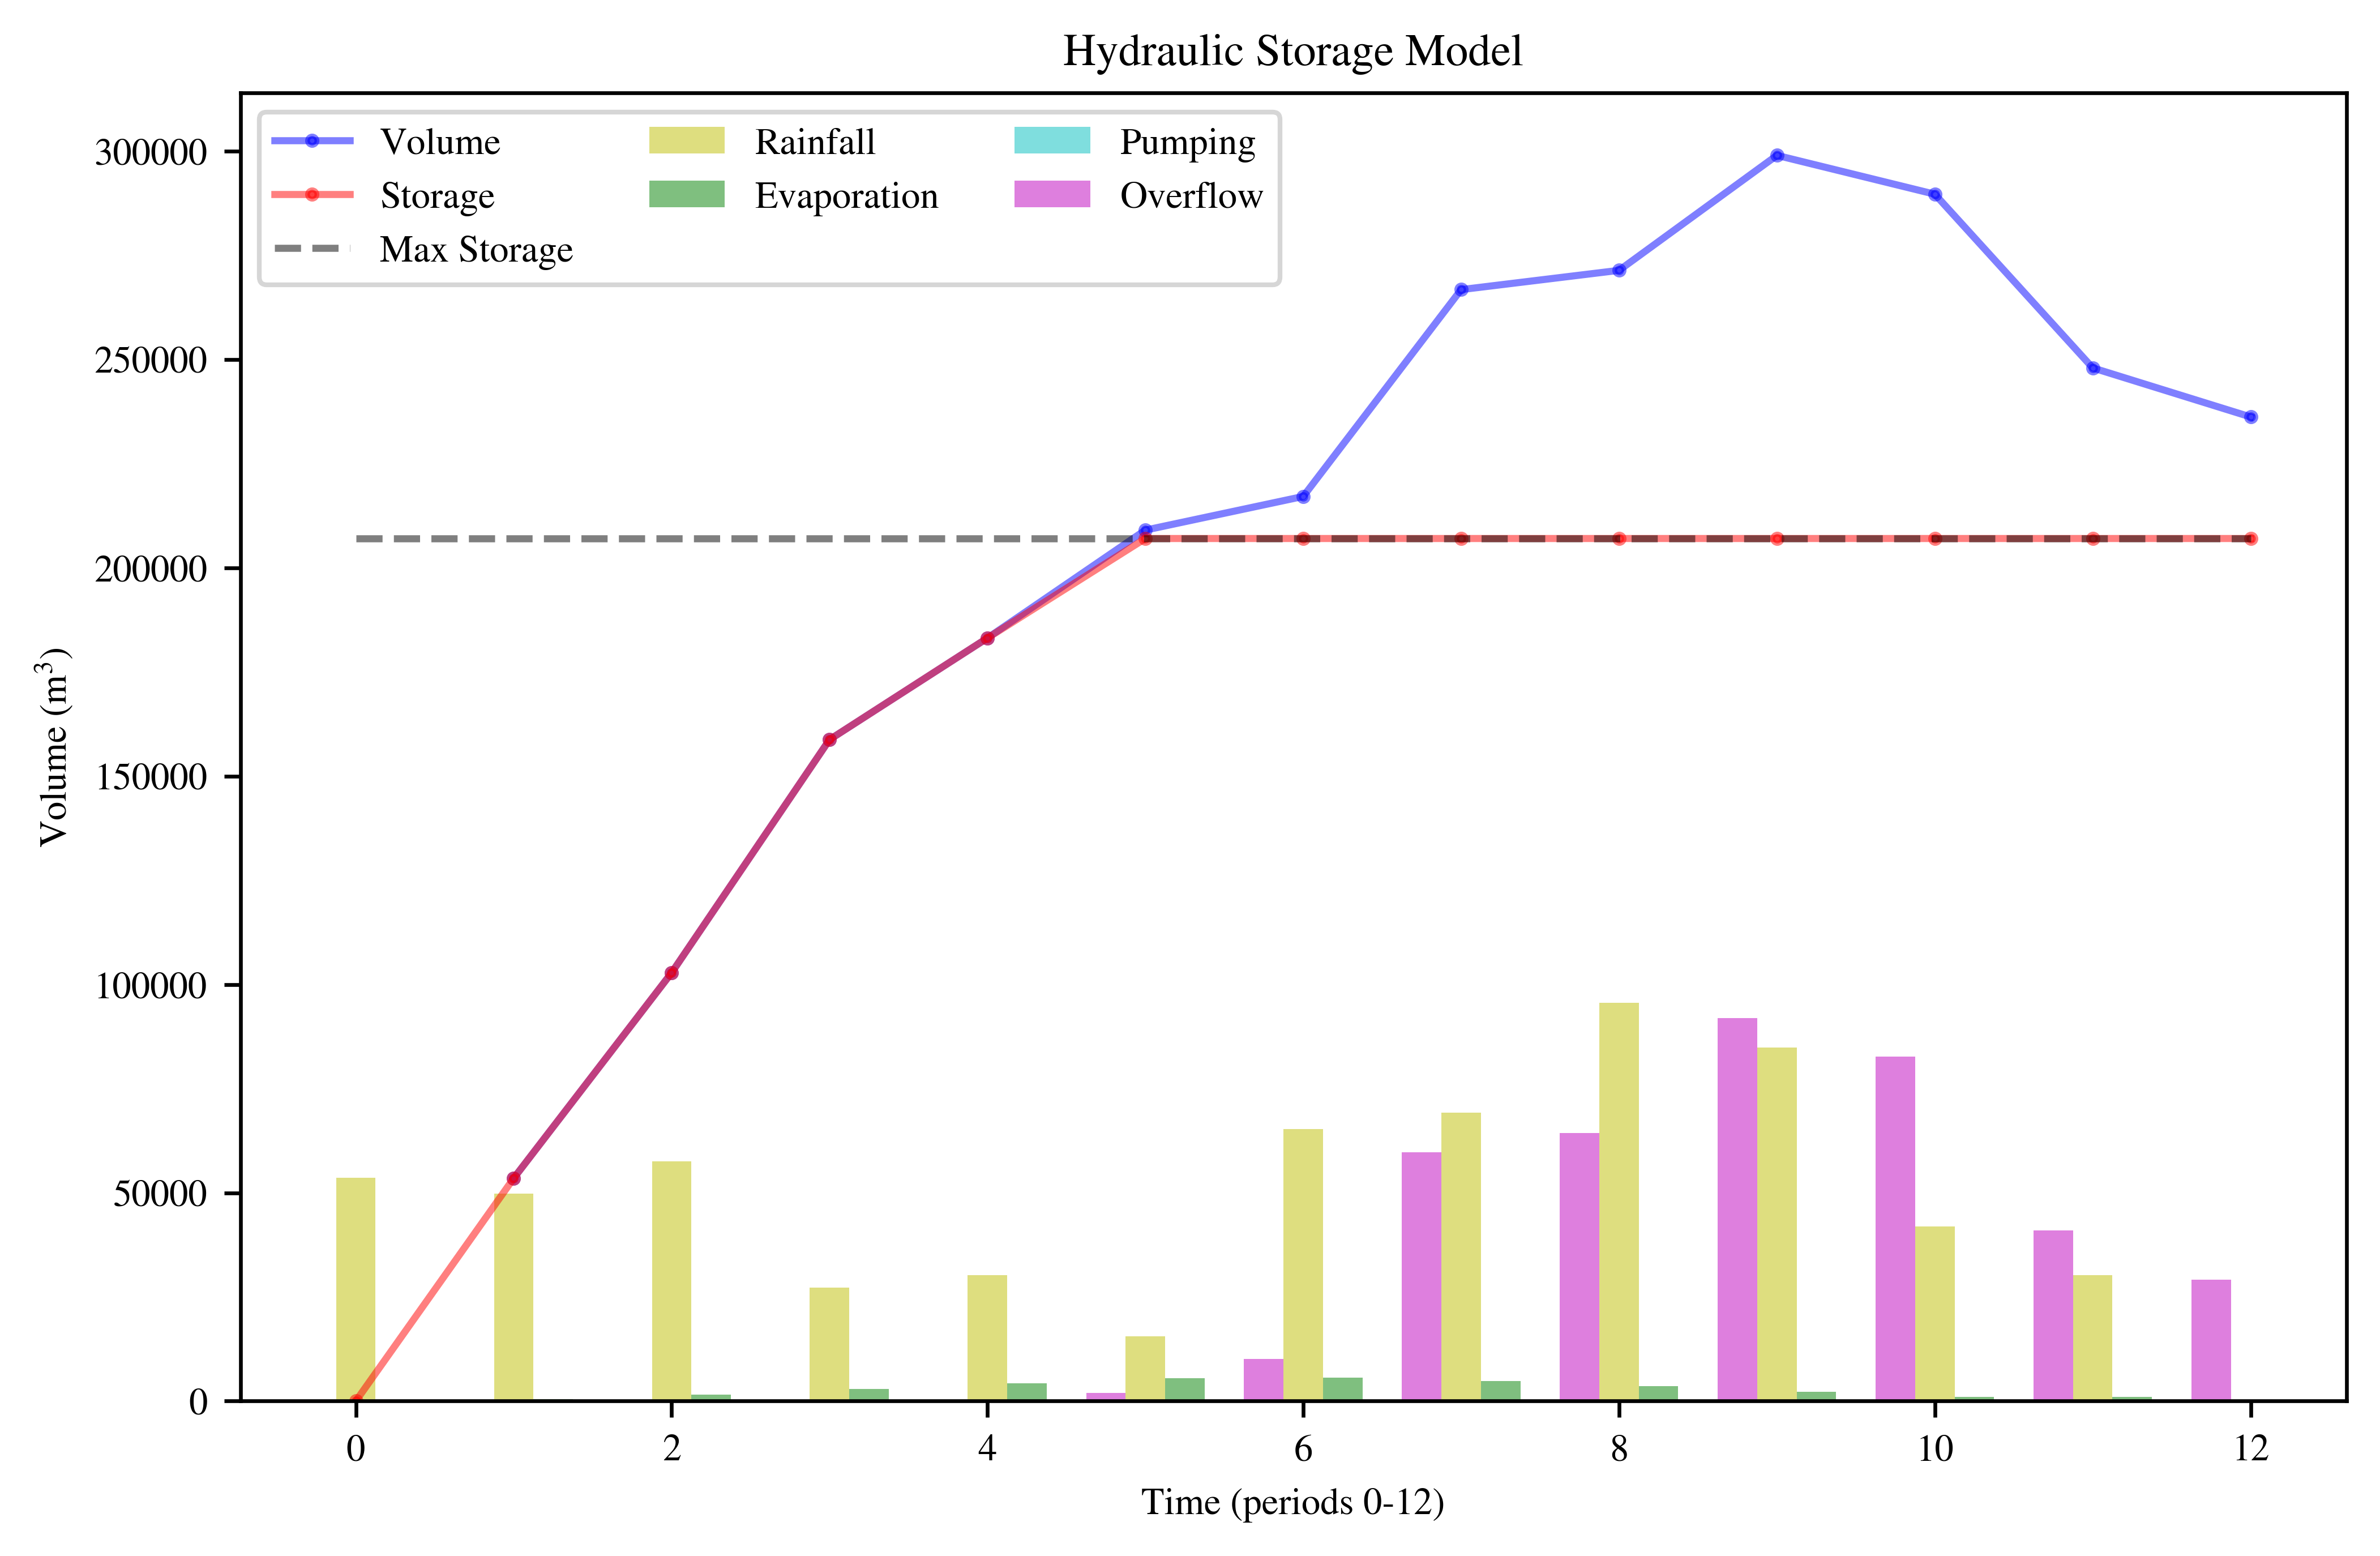

In [33]:
volume = np.array([model.V[i].value for i in model.K_points])
storage = np.array([model.S[i].value for i in model.K_points])
evaporation = np.array([model.E[i].value for i in model.K_periods])
pumping = np.array([model.Q[i].value for i in model.K_periods])
overflow = np.array([model.W[i].value for i in model.K_periods])

x_periods = np.arange(PRECIP.size)

plt.rcParams["figure.figsize"] = [8, 5]
plt.title("Hydraulic Storage Model")
plt.plot(
    volume, "-bo", alpha=0.5, label="Volume", markersize=2
)  # Could omit last/12-th point (volume[:-1])
plt.plot(storage, "-ro", alpha=0.5, label="Storage", markersize=2)  # sim.
plt.bar(
    x_periods,
    PRECIP,
    width=WIDTH,
    color="y",
    alpha=0.5,
    label="Rainfall",
)
plt.bar(
    x_periods + WIDTH,
    evaporation,
    width=WIDTH,
    color="g",
    alpha=0.5,
    label="Evaporation",
)
plt.bar(
    x_periods + 2 * WIDTH,
    pumping,
    color="c",
    width=WIDTH,
    alpha=0.5,
    label="Pumping",
)
plt.bar(
    x_periods + 3 * WIDTH,
    overflow,
    width=WIDTH,
    color="m",
    alpha=0.5,
    label="Overflow",
)
plt.hlines(
    y=MAX_VOLUME,
    xmin=0,
    xmax=N_POINTS,
    alpha=0.5,
    linestyles="dashed",
    label="Max Storage",
)

plt.xlabel(f"Time (periods 0-{N_POINTS})")
plt.ylabel("Volume (m$^3$)")
plt.legend(prop={"size": 8}, ncol=3)
plt.show()